# Script to plot PCoA and T-SNE from MARTi data

 Need to use the 24hr_env to have al the packages


In [1]:
import sklearn as sk
import numpy as np
import skbio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

from sklearn import preprocessing
from sklearn.manifold import TSNE
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from skbio.stats.ordination import pcoa 
from skbio import DistanceMatrix
from sklearn.metrics import pairwise_distances

from matplotlib import rcParams


Load in the data

In [16]:
#Loading in the data
# Marti just summed counts from Jul 2025 run min length 150
raw_data = pd.read_csv('../marti_outputs/marti_Jul_150_v2/summed_marti_assignments_lca_0.1_all_levels_2025-JUL-9_11-52-34.tsv', sep='\t')
raw_data.columns = [col.replace(' (samp_comp_CF_0624) Summed read count', '')
                       .replace(' (samp_comp_NHM_0624) Summed read count', '')
                    for col in raw_data.columns]

# Melt the data to long
raw_data_long = raw_data.melt(id_vars=['Name', 'NCBI ID', 'NCBI Rank'], var_name='Sample_ID', value_name='Count')


# Read in metadata
metadata = pd.read_csv('../metadata/Sample_table.csv')
# Replace "Micro" with "μ" in the Sample column
metadata['Sampler'] = metadata['Sampler'].str.replace('Micro', 'μ', regex=False)

# Merge the melted raw_data with seq_info on 'Sample_ID'
merged_data = pd.merge(raw_data_long, metadata, on='Sample_ID', how='left')

# #Filter to one taxonomic rank - species
filtered_data = merged_data[(merged_data['NCBI Rank'] == 'species') & (merged_data['Count'] > 0)] #for summarised
# # filtered_data = merged_data[(merged_data['Count'] > 0)] #for assigned

filtered_data = filtered_data.replace(',','', regex=True)
filtered_data['NumReads'] = pd.to_numeric(filtered_data['NumReads'], errors='coerce')
filtered_data['N50Length'] = pd.to_numeric(filtered_data['N50Length'], errors='coerce')
filtered_data['Longest'] = pd.to_numeric(filtered_data['Longest'], errors='coerce')

#calculating normalisd read counts - HP100k
filtered_data['read_HP100k'] = (filtered_data['Count'] / filtered_data['NumReads']) * 100000


## Plotting info

In [25]:
# Labels ---
# Create a dictionary to map sampler to descriptive labels
sampler_labels = {
    "Compact": "Coriolis Compact",
    "μ": "Coriolis μ",
    "Bobcat": "InnovaPrep Bobcat",
    "Cub": "InnovaPrep Cub",
    "Sass": "SASS 3100"
}

# Add a new column 'SamplerLabel' to metadata
metadata['SamplerLabel'] = metadata['Sampler'].map(sampler_labels)


# Better location names
location_labels = {
    "NHM": "Natural History Museum",
    "Cfarm": "Church Farm",
}

# Add a new column 'SamplerLabel' to metadata
metadata['LocLabel'] = metadata['Location'].map(location_labels)

# Location ---
## Colours

location_colors = {'Natural History Museum': '#008080',
                    'Church Farm': '#FF7F50'} 
metadata['Loc_colour'] = metadata['LocLabel'].map(location_colors)

## Markers
location_markers = {'Natural History Museum': '^', 
                    'Church Farm': 'o'}
metadata['Loc_marker'] = metadata['LocLabel'].map(location_markers)


# Samplers ---
## Colours
sampler_colors = {
    'Coriolis Compact': '#FAB296',
    'Coriolis μ': '#B2BEDB',
    'InnovaPrep Bobcat': '#9AD5C2',
    'InnovaPrep Cub': '#EFB0D5',
    'SASS 3100': '#C2E38C',
}

metadata['Samp_colour'] = metadata['SamplerLabel'].map(sampler_colors)

## Markers
marker_data = {
    'Bobcat': 'o',  # circle marker
    'Cub': '+',     # Use '+' for plus marker
    'Sass': 'x',     # Use 'x' for x marker (doesn't quite match r aesthetics)
    'μ': 's', # Use 's' for square marker
    'Compact': '^' # Use '^' for upward triangle marker
}

# Create a new column 'Marker' in metadata DataFrame based on 'Sampler'
metadata['Samp_Marker'] = metadata['Sampler'].map(marker_data)


## T-SNE

### Creating a presence/absence matrix at Genus level

In [18]:
#Extracting the genus information
# creating a table of just Names and samples
taxon_data = filtered_data[['Name', 'Sample_ID']]

#because this is a binary presence/absence matrix i only want unique taxa for each sample
#subset means we are dropping rows that have duplicate values in both sample & taxon cols
taxon_data = taxon_data.drop_duplicates(subset=['Name', 'Sample_ID'])

# Creating the matrix, for a t-SNE it's a case of presence or absence of each taxa
    # Taxa as columns and Sample_ID and rows
    # aggfunc - assigns a value of 1 to each cell in the binary matrix
    # fill_value - any missing values in the matrix set to 0

binary_matrix = pd.pivot_table(taxon_data, index='Sample_ID', columns='Name', aggfunc=lambda x: 1, fill_value=0)

# Name two different versions so the later code doesn't overwrite
binary_matrix_tsne = binary_matrix.copy()
binary_matrix_pcoa = binary_matrix.copy()

In [19]:
# Perform T-SNE on your binary matrix---------------------------------
#n_components - data is reduced to 2 components for x and y
tsne = TSNE(n_components=2, random_state=0)
# #T-SNE co-ordinates are stored in t-sne_results
tsne_results = tsne.fit_transform(binary_matrix_tsne)

# Extract T-SNE coordinates for x and y axes
tsne_x = tsne_results[:, 0]
tsne_y = tsne_results[:, 1] 

### Plotting

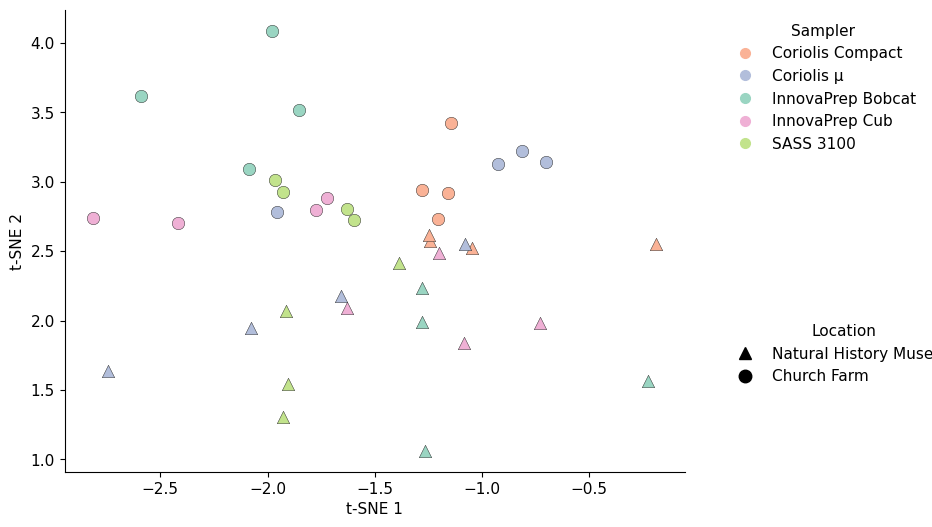

In [28]:

# Global style settings
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Arial']
rcParams['font.size'] = 11
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.grid'] = False

# Create the figure and axes explicitly
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust size as needed

# Proxy legend items
sampler_lines = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=7, label=label)
    for label, color in sampler_colors.items()
]

location_lines = [
    mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=9, label=label)
    for label, marker in location_markers.items()
]

# Plot the data
for i, barcode in enumerate(binary_matrix_tsne.index):
    color = metadata.loc[metadata['Sample_ID'] == barcode, 'Samp_colour'].values[0]
    marker = metadata.loc[metadata['Sample_ID'] == barcode, 'Loc_marker'].values[0]
    ax.scatter(tsne_x[i], tsne_y[i], color=color, marker=marker, s=80, edgecolors='#101010', linewidths=0.3)

# Add legends
legend1 = ax.legend(handles=location_lines, title='Location', loc='upper left', bbox_to_anchor=(1.05, 0.35), frameon=False)
legend2 = ax.legend(handles=sampler_lines, title='Sampler', loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
ax.add_artist(legend1)

# Label axes
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")

# Save the figure properly
fig.savefig("../Images/Ordination/tsne_species_marti.pdf", bbox_inches='tight', dpi=300, format='pdf')


## PCoA 

### Prepare the matrix data

Jaccard to be caclulated on binary matrix, decided to go with BC instead which uses abundance data

In [ ]:
# # Keep a reference to the original index
# original_index = binary_matrix_pcoa.index

# # Convert to numpy array
# binary_matrix_pcoa = np.array(binary_matrix_pcoa)

# # Calculate the dissimilarity matrix
# dissimilarity_matrix = pairwise_distances(binary_matrix_pcoa, metric='jaccard')
# # Perform PCoA on dissimilarity matrix
# pcoa_results = pcoa(dissimilarity_matrix)

# # Access the PCoA results
# eigvals = pcoa_results.eigvals
# samples = pcoa_results.samples

# # Scale the samples for better visualization
# scale_factor = 10
# scaled_samples = samples * scale_factor

# # Access the PCoA scores from the OrdinationResults object
# pcoa_scores = pcoa_results.samples.values

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.06796680994550604 and the largest is 1.5952069298406755.
  warn(


Need the abundance data in the matrix for BC

In [21]:
# Extract relevant columns: sample ID and taxon (and any abundance field)
taxon_data = filtered_data[['Name', 'Sample_ID', 'read_HP100k']]

# Step 2: Group by sample and taxon, and sum read_HP100k values - in case taxa appear more than once per sample
abundance_data = taxon_data.groupby(['Sample_ID', 'Name'])['read_HP100k'].sum().reset_index()

# Step 3: Pivot to get taxa as columns, samples as rows, values = abundance
abundance_matrix = abundance_data.pivot_table(
    index='Sample_ID',
    columns='Name',
    values='read_HP100k',
    fill_value=0
)

# Keep a reference to the original index
original_index = abundance_matrix.index

# Caculate the dissimilarity matrix using Bray-Curtis dissimilarity
dissimilarity_matrix = pairwise_distances(abundance_matrix.values, metric='braycurtis')

# Perform PCoA
pcoa_results = pcoa(dissimilarity_matrix)

# Extract results
eigvals = pcoa_results.eigvals
samples = pcoa_results.samples

# Final scores
pcoa_scores = samples.values

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.06893266953594225 and the largest is 2.2150750441254536.
  warn(


In [22]:
# Get eigenvalues
eigvals = pcoa_results.eigvals

# Calculate variance explained (as proportions)
variance_explained = eigvals / eigvals.sum()

# Get PC1 and PC2 variance as percentages
pc1_var = variance_explained.iloc[0] * 100
pc2_var = variance_explained.iloc[1] * 100

# Print them nicely
print(f"PC1 explains {pc1_var:.2f}% of the variance")
print(f"PC2 explains {pc2_var:.2f}% of the variance")


PC1 explains 19.55% of the variance
PC2 explains 12.84% of the variance


### Plotting

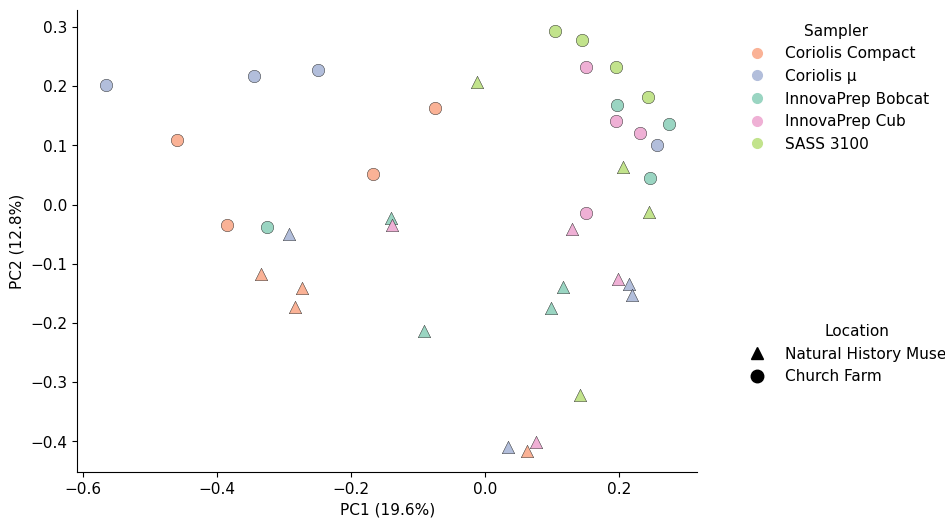

In [27]:
# Global style settings
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Arial']
rcParams['font.size'] = 11
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.grid'] = False

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot: colour by location, marker by sampler
for i, barcode in enumerate(original_index):
    color = metadata.loc[metadata['Sample_ID'] == barcode, 'Samp_colour'].values[0]
    marker = metadata.loc[metadata['Sample_ID'] == barcode, 'Loc_marker'].values[0]
    ax.scatter(pcoa_scores[i, 0], pcoa_scores[i, 1],
               color=color, marker=marker,
               s=80, edgecolors='#101010', linewidths=0.3)

# Proxy legend items
sampler_lines = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=7, label=label)
    for label, color in sampler_colors.items()
]

location_lines = [
    mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=9, label=label)
    for label, marker in location_markers.items()
]

# Add legends (non-overlapping)
legend1 = ax.legend(handles=location_lines, title='Location',
                    loc='upper left', bbox_to_anchor=(1.05, 0.35), frameon=False)

legend2 = ax.legend(handles=sampler_lines, title='Sampler',
                    loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

ax.add_artist(legend1)

# Axes labels and title
ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)")
ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)")

# Save properly with full legend
fig.savefig("../Images/Ordination/pcoa_BC_species_marti.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()


# Plotting both as one figure

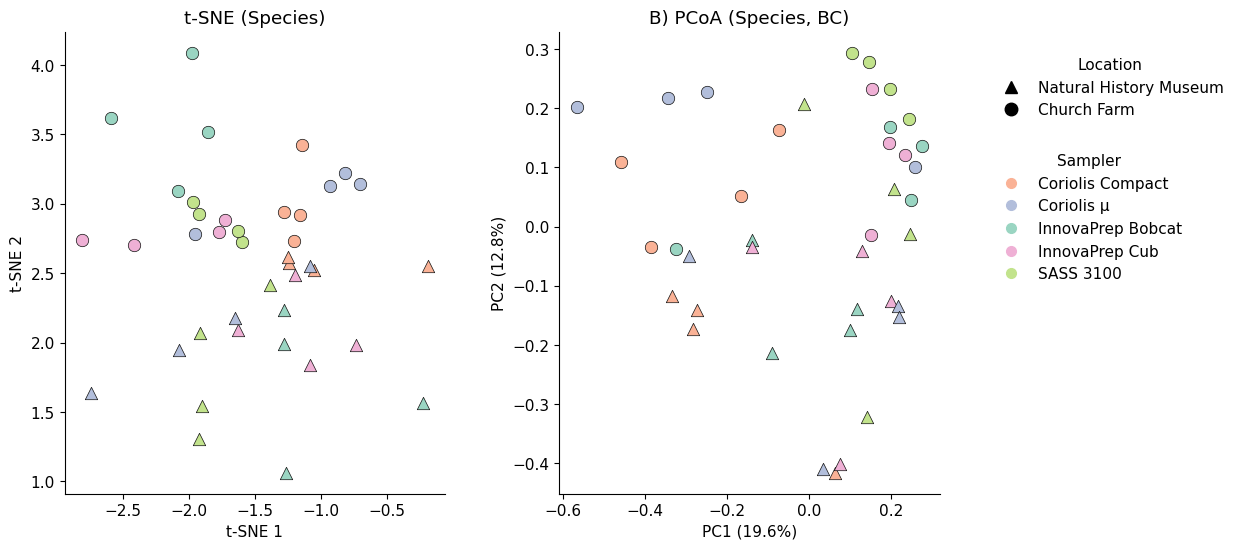

In [26]:
# Style settings
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Arial']
rcParams['font.size'] = 11
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.grid'] = False

# Create figure with 2 subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# === t-SNE plot ===
for i, barcode in enumerate(binary_matrix_tsne.index):
    color = metadata.loc[metadata['Sample_ID'] == barcode, 'Samp_colour'].values[0]
    marker = metadata.loc[metadata['Sample_ID'] == barcode, 'Loc_marker'].values[0]
    axs[0].scatter(tsne_x[i], tsne_y[i], color=color, marker=marker,
                   s=80, edgecolors='#101010', linewidths=0.5)

axs[0].set_title("t-SNE (Species)")
axs[0].set_xlabel("t-SNE 1")
axs[0].set_ylabel("t-SNE 2")

# === PCoA plot ===
for i, barcode in enumerate(original_index):
    color = metadata.loc[metadata['Sample_ID'] == barcode, 'Samp_colour'].values[0]
    marker = metadata.loc[metadata['Sample_ID'] == barcode, 'Loc_marker'].values[0]
    axs[1].scatter(pcoa_scores[i, 0], pcoa_scores[i, 1], color=color, marker=marker,
                   s=80, edgecolors='#101010', linewidths=0.5)

axs[1].set_title("B) PCoA (Species, BC)")
axs[1].set_xlabel(f"PC1 ({pc1_var:.1f}%)")
axs[1].set_ylabel(f"PC2 ({pc2_var:.1f}%)")

# === Shared legend (outside plot) ===

# Proxy legend items
sampler_lines = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=7, label=label)
    for label, color in sampler_colors.items()
]

location_lines = [
    mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=9, label=label)
    for label, marker in location_markers.items()
]

# Shared legends added to the figure directly
fig.legend(handles=location_lines, title='Location',
           loc='upper left', bbox_to_anchor=(0.78, 0.86), frameon=False)

fig.legend(handles=sampler_lines, title='Sampler',
           loc='upper left', bbox_to_anchor=(0.78, 0.70), frameon=False)


# Adjust spacing for legends
plt.subplots_adjust(right=0.75, wspace=0.3)

# Save final figure
fig.savefig("../Images/Ordination/panel_tsne_pcoa_marti.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()
